In [35]:
import pandas as pd

# Import data into pandas dataframe
df: pd.DataFrame = pd.read_csv('presidents_data_set.csv')


# Preview the top of the dataset to ensure we're loading the right thing!
df.head()

,PRESIDENT,BIRTH DATE,BIRTH PLACE,DEATH DATE,LOCATION OF DEATH
0,George Washington,"Feb 22, 1732","Westmoreland Co., Va.","Dec 14, 1799","Mount Vernon, Va."
1,John Adams,"Oct 30, 1735","Quincy, Mass.","July 4, 1826","Quincy, Mass."
2,Thomas Jefferson,"Apr 13, 1743","Albemarle Co., Va.","July 4, 1826","Albemarle Co., Va."
3,James Madison,"Mar 16, 1751","Port Conway, Va.","June 28, 1836","Orange Co., Va."
4,James Monroe,"Apr 28, 1758","Westmoreland Co., Va.","July 4, 1831","New York, New York"


In [36]:
# Inspect a sample raw value of the birth date and death date values as
# we'll be deriving our new columns from them
raw_sample_birth_date = df.at[0, 'BIRTH DATE']
raw_sample_death_date = df.at[0, 'DEATH DATE']

print(f"Raw Birth Date: {raw_sample_birth_date}, Raw Death Date: {raw_sample_death_date}")

Raw Birth Date: Feb 22, 1732, Raw Death Date: Dec 14, 1799


Nice! Looks like the raw data is in the format of MMM d, yyyy.
Though we should probably validate that all of the data follows this format 
in order to avoid complications later on (no one expects malformed data!)

In [37]:
from datetime import datetime

# Lets build a quick function that will validate the format
def is_valid_format(date_str: str, fmt: str) -> bool:
    try:
        datetime.strptime(date_str, fmt)
    except ValueError:
      return False
    
    return True

# Now we can use that function to apply the function to all elements in list and then use the builtin `all()` to validate
is_birth_date_data_valid = all([is_valid_format(bd, "%b %d, %Y") for bd in df['BIRTH DATE'].dropna().tolist()])
is_death_date_data_valid = all([is_valid_format(dd, "%b %d, %Y") for dd in df['DEATH DATE'].dropna().tolist()])

print(f"Valid birth date data: {is_birth_date_data_valid}")
print(f"Valid death date data: {is_death_date_data_valid}")



Valid birth date data: False
Valid death date data: False


Oh no! It seems like all of our data does not conform to the same format, so we need to convert it to a standard format in order to use it for analysis. Just a note; we could probably skip the validation step above and perform validation and conversion at the same time. Though I'm performing this analyis sequentially so I only thought of performing both simultaneously after the fact 😅.

In [40]:
# Do the conversion for the date columns
# Note; the format="mixed" argument can be dangerous since it can iterpret days/years incorrectly
# It's safe here since a visual inspection of the dataset reveals that all date values start with
# spelled out Month value

df_valid = df.copy()
df_valid['BIRTH DATE'] = pd.to_datetime(df_valid['BIRTH DATE'], format='mixed')
df_valid['DEATH DATE'] = pd.to_datetime(df_valid['DEATH DATE'], format='mixed')

# Lets see how that looks
df_valid.head()


,PRESIDENT,BIRTH DATE,BIRTH PLACE,DEATH DATE,LOCATION OF DEATH
0,George Washington,1732-02-22,"Westmoreland Co., Va.",1799-12-14,"Mount Vernon, Va."
1,John Adams,1735-10-30,"Quincy, Mass.",1826-07-04,"Quincy, Mass."
2,Thomas Jefferson,1743-04-13,"Albemarle Co., Va.",1826-07-04,"Albemarle Co., Va."
3,James Madison,1751-03-16,"Port Conway, Va.",1836-06-28,"Orange Co., Va."
4,James Monroe,1758-04-28,"Westmoreland Co., Va.",1831-07-04,"New York, New York"


Nice! Now we have valid data and we convert all of the data string data to a datetime object which will make creating the dervied columns a lot easier. Let's go ahead and get started.

In [64]:
from dateutil.relativedelta import relativedelta

# Lets make a function that will aid with datetime differences
def calc_time_diff(start_date: pd.Timestamp, end_date: pd.Timestamp, period: str):
    if pd.isnull(end_date):
        end_date = pd.Timestamp.today()
    
    diff: int = 0
    if period == "years" or period == "months":
        delta = relativedelta(end_date, start_date)
        if period == "years":
            diff = delta.years
        else:
            diff = (delta.years * 12) + delta.months
    elif period == "days":
        diff = (end_date - start_date).days
                
    return diff

df_derived = df_valid.copy()

# Time to calculate all of the derived columns
df_derived['year_of_birth'] = df_derived['BIRTH DATE'].dt.year
df_derived['lived_years'] = df_derived.apply(lambda row: calc_time_diff(row['BIRTH DATE'], row['DEATH DATE'], "years"), axis=1)
df_derived['lived_months'] = df_derived.apply(lambda row: calc_time_diff(row['BIRTH DATE'], row['DEATH DATE'], "months"), axis=1)
df_derived['lived_days'] = df_derived.apply(lambda row: calc_time_diff(row['BIRTH DATE'], row['DEATH DATE'], "days"), axis=1)

# Lets see how it looks!
df_derived.head()

,PRESIDENT,BIRTH DATE,BIRTH PLACE,DEATH DATE,LOCATION OF DEATH,year_of_birth,lived_years,lived_months,lived_days
0,George Washington,1732-02-22,"Westmoreland Co., Va.",1799-12-14,"Mount Vernon, Va.",1732,67,813,24767
1,John Adams,1735-10-30,"Quincy, Mass.",1826-07-04,"Quincy, Mass.",1735,90,1088,33119
2,Thomas Jefferson,1743-04-13,"Albemarle Co., Va.",1826-07-04,"Albemarle Co., Va.",1743,83,998,30397
3,James Madison,1751-03-16,"Port Conway, Va.",1836-06-28,"Orange Co., Va.",1751,85,1023,31150
4,James Monroe,1758-04-28,"Westmoreland Co., Va.",1831-07-04,"New York, New York",1758,73,878,26729


Looks pretty good! Now time to calculate and output the rankings 😎

In [66]:
# Longest lived top 10 ranking; go Jimmy!
df_rank_longest_lived = df_derived.sort_values('lived_days', ascending=False)
df_rank_longest_lived.head(10)

,PRESIDENT,BIRTH DATE,BIRTH PLACE,DEATH DATE,LOCATION OF DEATH,year_of_birth,lived_years,lived_months,lived_days
37,Jimmy Carter,1924-10-01,"Plains, Georgia",NaT,NaN,1924,98,1184,36038
39,George Bush,1924-06-12,"Milton, Mass.",2018-11-30,"Houston, Texas",1924,94,1133,34504
36,Gerald Ford,1913-07-14,"Omaha, Nebraska",2006-12-26,"Rancho Mirage, Cal.",1913,93,1121,34133
38,Ronald Reagan,1911-02-06,"Tampico, Illinois",2004-06-05,"Los Angeles, Cal.",1911,93,1119,34088
1,John Adams,1735-10-30,"Quincy, Mass.",1826-07-04,"Quincy, Mass.",1735,90,1088,33119
29,Herbert Hoover,1874-08-10,"West Branch, Iowa",1964-10-20,"New York, New York",1874,90,1082,32943
31,Harry S. Truman,1884-05-08,"Lamar, Missouri",1972-12-26,"Kansas City, Missouri",1884,88,1063,32373
3,James Madison,1751-03-16,"Port Conway, Va.",1836-06-28,"Orange Co., Va.",1751,85,1023,31150
2,Thomas Jefferson,1743-04-13,"Albemarle Co., Va.",1826-07-04,"Albemarle Co., Va.",1743,83,998,30397
35,Richard Nixon,1913-01-09,"Yorba Linda, Cal.",1994-04-22,"New York, New York",1913,81,975,29688


In [67]:
# Shortest lived top 10 ranking
df_rank_shortest_lived = df_derived.sort_values('lived_days', ascending=True)
df_rank_shortest_lived.head(10)

,PRESIDENT,BIRTH DATE,BIRTH PLACE,DEATH DATE,LOCATION OF DEATH,year_of_birth,lived_years,lived_months,lived_days
33,John F. Kennedy,1917-05-29,"Brookline, Mass.",1963-11-22,"Dallas, Texas",1917,46,557,16978
19,James A. Garfield,1831-11-19,"Cuyahoga Co., Ohio",1881-09-19,"Elberon, New Jersey",1831,49,598,18202
10,James K. Polk,1795-11-02,"Mecklenburg Co., N.C.",1849-06-15,"Nashville, Tennessee",1795,53,643,19583
15,Abraham Lincoln,1809-02-12,"LaRue Co., Kentucky",1865-04-15,"Washington, D.C.",1809,56,674,20516
20,Chester Arthur,1829-10-05,"Fairfield, Vermont",1886-11-18,"New York, New York",1829,57,685,20863
27,Warren G. Harding,1865-11-02,"Morrow County, Ohio",1923-08-02,"San Francisco, Cal.",1865,57,693,21091
23,William McKinley,1843-01-29,"Niles, Ohio",1901-09-14,"Buffalo, New York",1843,58,703,21412
24,Theodore Roosevelt,1858-10-27,"New York, New York",1919-01-06,"Oyster Bay, New York",1858,60,722,21985
28,Calvin Coolidge,1872-07-04,"Plymouth, Vermont",1933-01-05,"Northampton, Mass.",1872,60,726,22099
42,Barack Obama,1961-08-04,"Honolulu, Hawaii",NaT,NaN,1961,61,741,22582


In [102]:
import numpy as np
import math

# For weighted average, I decided to weight by the decade the president was born in
# so we'll need a function to calculate the decade from the birth year
def decade_from_year(year: int):
    return math.floor(year / 10.0) * 10

df_derived_groups = df_derived.copy()

df_derived_groups['decade'] = df_derived.apply(lambda row: decade_from_year(row['year_of_birth']), axis=1)

weighted_avg = np.average(a=df_derived_groups['lived_days'], weights=df_derived_groups['decade'])

# Create new data frame for lived_days summary data
df_lived_days_summary = pd.DataFrame({
    'mean': [df_derived_groups['lived_days'].mean()],
    'weighted_avg': [weighted_avg],
    'median': [df_derived_groups['lived_days'].median()],
    'mode': [df_derived_groups['lived_days'].mode()[0]],
    'max': [df_derived_groups['lived_days'].max()],
    'min': [df_derived_groups['lived_days'].min()],
    'std': [df_derived_groups['lived_days'].std()]
})

# Output the summary data
df_lived_days_summary.head()

,mean,weighted_avg,median,mode,max,min,std
0,26446.044444,26465.047217,26227.0,16978,36038,16978,4600.48696


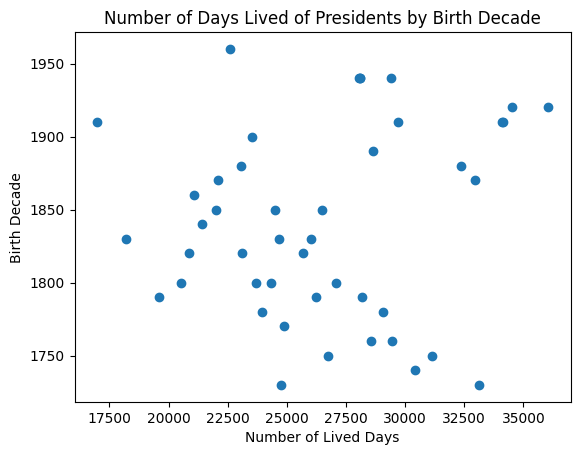

In [111]:
import matplotlib.pyplot as plot

# Lastly, let's make a scatter plot to visualize the data, we'll plot by years lived and centurty born
fig = plot.scatter(df_derived_groups['lived_days'], df_derived_groups['decade'])
plot.xlabel('Number of Lived Days')
plot.ylabel('Birth Decade')
plot.title('Number of Days Lived of Presidents by Birth Decade')

plot.show()
